In [4]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
import glob

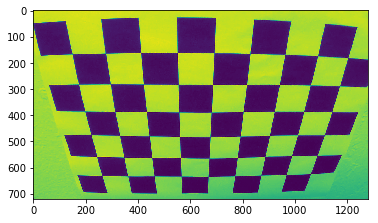

In [45]:
# Visualize a  image
image  = mpimg.imread("./camera_cal/calibration2.jpg")
plt.imshow(image)
gray  =  cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
plt.imshow(gray)
           

In [46]:
# Function  to  Plot subplots to compare before and after images
def  plot(image1 ,image2, before , after):
    fig = plt.figure()
    fig.set_figheight(20)
    fig.set_figwidth(20)
    a=fig.add_subplot(1,2,1)
    imgplot  = plt.imshow(image1)
    a.set_title(before, fontsize=30)
    plt.colorbar(ticks=[0.1,0.3,0.5,0.7] , orientation='horizontal')
    a = fig.add_subplot(1,2,2)
    imgplot = plt.imshow(image2)
    imgplot.set_clim(0.0,0.7)
    a.set_title(after, fontsize=30)
    plt.colorbar(ticks=[0.1,0.3,0.5,0.7], orientation='horizontal')
    plt.show()

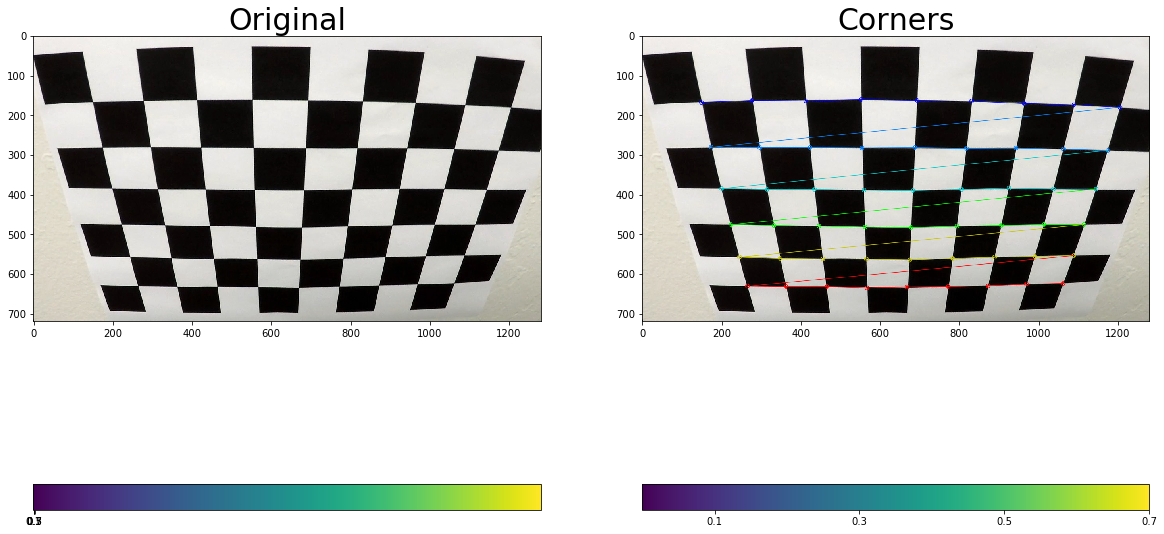

In [47]:
#  Calibrate the camera images  and find distortion  matrix and co-efficients
objpoints = []
imagepoints = []
images  = glob.glob('./camera_cal/calibration*.jpg')

# Lets  prepare object points for the  9x6 chessboard
objp = np.zeros((6*9,3),np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)


# Read all the Calibrations images and get their corners 
for imgname  in images:
    image = mpimg.imread(imgname)
    beforeimage = image.copy()
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    ret ,corners = cv2.findChessboardCorners(gray,(9,6),None)
    


    if ret == True:
        imagepoints.append(corners)
        objpoints.append(objp)
        image  = cv2.drawChessboardCorners(image, (9,6),corners,ret)
        #print(imgname)
        # Plot a  single Corners image 
        if imgname =='./camera_cal\calibration2.jpg':
            plot(beforeimage, image , 'Original', 'Corners')
            
plt.show()

# Use calibrate camera function to find the distortion matrix and co-efficents
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imagepoints, gray.shape[::-1], None, None)


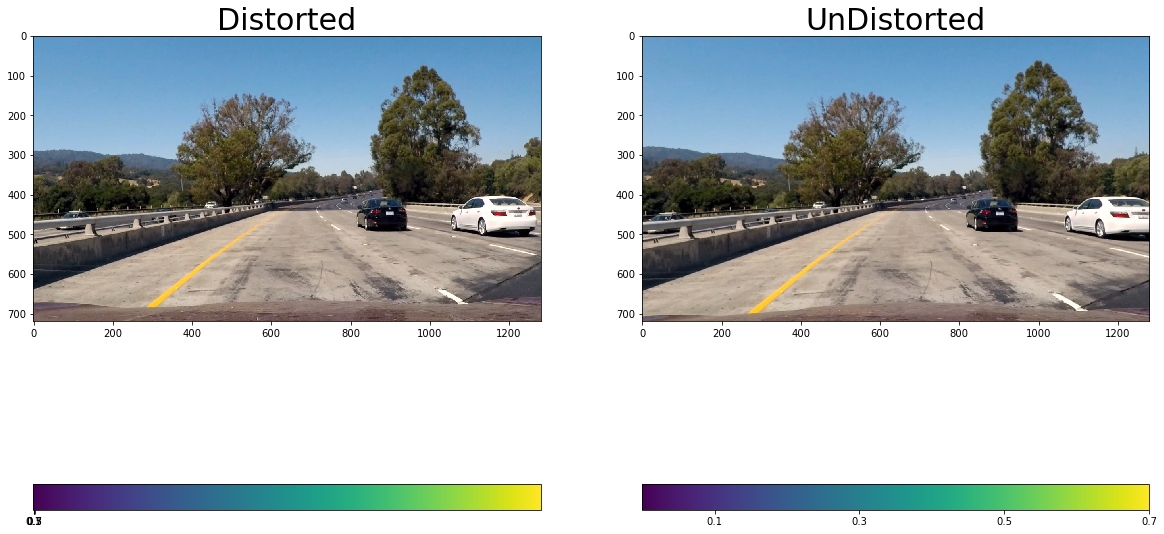

In [44]:
# Apply on to raw  images 
raw =  mpimg.imread("./test_images/test1.jpg")
#plt.imshow(raw)
dst  = cv2.undistort(raw ,mtx,dist,None,mtx)

plot(raw, dst, 'Distorted', 'UnDistorted')


In [7]:
# Define a function that applies Sobel x or y, 
# then takes an absolute value and applies a threshold.
# Note: calling your function with orient='x', thresh_min=5, thresh_max=100
# should produce output like the example image shown above this quiz.
def abs_sobel_thresh(img, orient='x',sobel_kernel=3, thresh=(0,255)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    # 3) Take the absolute value of the derivative or gradient
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    # 6) Return this mask as your binary_output image
    gray =  cv2.cvtColor(img , cv2.COLOR_RGB2GRAY)
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray , cv2.CV_64F,1,0, ksize=sobel_kernel)) 
    if orient ==  'y':
        abs_sobel = np.absolute(cv2.Sobel(gray , cv2.CV_64F ,0,1, ksize= sobel_kernel))
    scaled_sobel = np.uint8(255*abs_sobel/(np.max(abs_sobel)))
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1]) ] =1
    return binary_output


In [8]:
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    # 2) Take the gradient in x and y separately
    # 3) Calculate the magnitude 
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    # 5) Create a binary mask where mag thresholds are met
    # 6) Return this mask as your binary_output image
    gray  = cv2.cvtColor(img , cv2.COLOR_RGB2GRAY)
    abs_sobelX = cv2.Sobel(gray , cv2.CV_64F , 1,0, ksize=sobel_kernel)
    abs_sobelY = cv2.Sobel(gray, cv2.CV_64F, 0,1 , ksize= sobel_kernel)
    
    grad_max  = np.sqrt(abs_sobelX**2)+(abs_sobelY**2)
    
    scale_factor  = np.max(grad_max)/255
    
    grad = (grad_max/scale_factor).astype(np.uint8)
    
    binary_output = np.zeros_like(grad)
    binary_output[(grad >=mag_thresh[0]) & (grad <= mag_thresh[1])] = 1
    return binary_output

In [9]:
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    # 2) Take the gradient in x and y separately
    # 3) Take the absolute value of the x and y gradients
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    # 5) Create a binary mask where direction thresholds are met
    # 6) Return this mask as your binary_output image
    gray  = cv2.cvtColor(img , cv2.COLOR_RGB2GRAY)
    abs_sobelX = cv2.Sobel(gray , cv2.CV_64F , 1,0, ksize=sobel_kernel)
    abs_sobelY = cv2.Sobel(gray, cv2.CV_64F, 0,1 , ksize= sobel_kernel)
    dir_grad = np.arctan2(np.absolute(abs_sobelY) , np.absolute(abs_sobelX))
    
    binary_output = np.zeros_like(dir_grad)
    binary_output[(dir_grad >= thresh[0]) & (dir_grad <= thresh[1])] =1 
    return binary_output

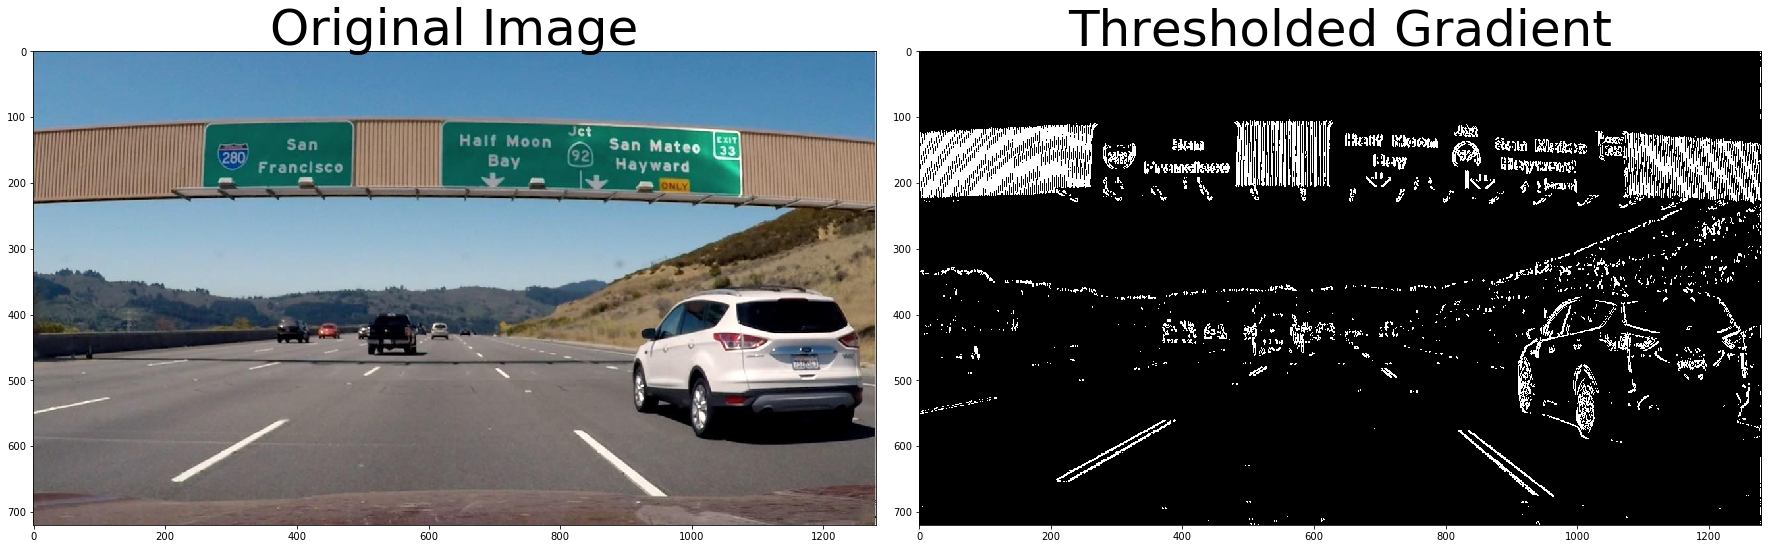

In [12]:
# Read in an image and grayscale it
%matplotlib inline
image = mpimg.imread('./signs_vehicles_xygrad.png')
# Choose a Sobel kernel size
ksize = 3 # Choose a larger odd number to smooth gradient measurements

# Apply each of the thresholding functions
gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=ksize, thresh=(0, 255))
grady = abs_sobel_thresh(image, orient='y', sobel_kernel=ksize, thresh=(0, 255))
mag_binary = mag_thresh(image, sobel_kernel=ksize, mag_thresh=(0, 255))
dir_binary = dir_threshold(image, sobel_kernel=ksize, thresh=(0, np.pi/2))

combined = np.zeros_like(dir_binary)
combined[((gradx==1) & (grady==1)) |((mag_binary ==1) & (dir_binary == 1))] = 1

    
# Run the function
grad_binary = abs_sobel_thresh(image, orient='x', sobel_kernel=ksize ,thresh_mn=(20,100))
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(grad_binary, cmap='gray')
ax2.set_title('Thresholded Gradient', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)